# Import modules and libraries

In [0]:
import numpy as np # linear algebra
import os
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
from pandas_datareader import data

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# Using `yfinance` to get data

In [0]:
!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf

In [0]:
msft = yf.Ticker("MSFT")

In [0]:
msft.info

In [6]:
msft.history(period="max")
#msft.actions
#msft.dividends

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.06,0.07,0.06,0.06,1031788800,0.0,0.0
1986-03-14,0.06,0.07,0.06,0.06,308160000,0.0,0.0
1986-03-17,0.06,0.07,0.06,0.07,133171200,0.0,0.0
1986-03-18,0.07,0.07,0.06,0.06,67766400,0.0,0.0
1986-03-19,0.06,0.06,0.06,0.06,47894400,0.0,0.0
...,...,...,...,...,...,...,...
2020-04-30,180.00,180.40,176.23,179.21,53875900,0.0,0.0
2020-05-01,175.80,178.64,174.01,174.57,39370500,0.0,0.0
2020-05-04,174.49,179.00,173.80,178.84,30372900,0.0,0.0


In [0]:
def stocks_data(symbols, start_date, end_date):
    dates = pd.date_range(start_date,end_date,freq='B')
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        tick = yf.Ticker(symbol)
        df_temp = tick.history(start=start_date, end=end_date).filter(['Date', 'Close'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

In [0]:
start_date = '2015-01-02'
end_date = '2019-12-31'

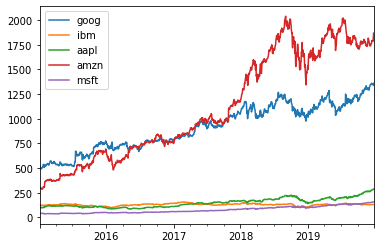

In [9]:
symbols = ['goog','ibm','aapl','amzn','msft']
df = stocks_data(symbols, start_date, end_date)
df.fillna(method='pad')
#print(df)
df.interpolate().plot()
plt.show()

In [10]:
df.head()

,goog,ibm,aapl,amzn,msft
2015-01-02,523.37,127.53,100.22,308.52,41.86
2015-01-05,512.46,125.52,97.39,302.19,41.48
2015-01-06,500.59,122.82,97.40,295.29,40.87
2015-01-07,499.73,122.01,98.77,298.42,41.39
2015-01-08,501.30,124.67,102.56,300.46,42.61


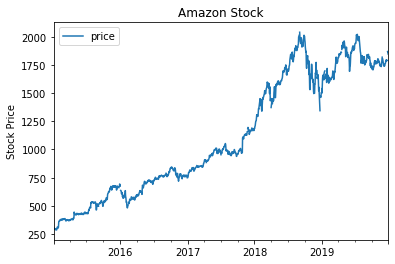

In [11]:
df_amzn = df.filter(['Date', 'amzn'])
df_amzn = df_amzn.rename(columns={'amzn': 'price'})
df_amzn.plot()
plt.ylabel("Stock Price")
plt.title("Amazon Stock")
plt.show()

In [12]:
df_amzn.head()

,price
2015-01-02,308.52
2015-01-05,302.19
2015-01-06,295.29
2015-01-07,298.42
2015-01-08,300.46


In [0]:
df_amzn=df_amzn.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
df_amzn['price'] = scaler.fit_transform(df_amzn['price'].values.reshape(-1,1))

In [14]:
df_amzn.head()

,price
2015-01-02,-0.975385
2015-01-05,-0.982608
2015-01-06,-0.990482
2015-01-07,-0.986911
2015-01-08,-0.984583


# Loading data

In [0]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    #data_raw = stock.as_matrix() 
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:] # ":-1" slices the array to omit the last element
    y_train = data[:train_set_size,-1,:]  # "-1" pick the last element to get rid of that dimension
    
    x_test = data[train_set_size:,:-1]    # = data[train_set_size:,:-1:]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [16]:
look_back = 20 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_amzn, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1026, 19, 1)
y_train.shape =  (1026, 1)
x_test.shape =  (257, 19, 1)
y_test.shape =  (257, 1)


In [0]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [18]:
y_train.size(),x_train.size()

(torch.Size([1026, 1]), torch.Size([1026, 19, 1]))

In [0]:
n_steps = look_back-1
num_epochs = 100 

# Vanilla RNN model

## Creating the model

In [0]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_size, seq_length, feature_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_dim)
        # hidden (n_layers, batch_size, hidden_dim)
        # out (batch_size, time_step, hidden_dim) 

        # get RNN outputs
        out, hidden = self.rnn(x, hidden)

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out, hidden

In [0]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

In [22]:
rnn = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [23]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in rnn.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in rnn.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

3,265 total parameters.
3,265 training parameters.


In [0]:
loss_fn = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(rnn.parameters(), lr=0.01)

In [0]:
hist = np.zeros(num_epochs)
seq_dim =look_back-1

# Initialise hidden state
hidden = None

In [26]:
y_train_pred_rnn, hidden = rnn(x_train, None)
print('y_train.shape = ',y_train.shape)
print('y_train_pred_rnn.shape = ',y_train_pred_rnn.shape)
loss = loss_fn(y_train_pred_rnn, y_train)

y_train.shape =  torch.Size([1026, 1])
y_train_pred_rnn.shape =  torch.Size([1026, 1])


In [27]:
for t in range(num_epochs):
    
    # Forward pass
    y_train_pred_rnn, hidden = rnn(x_train, hidden)
    hidden = hidden.data

    loss = loss_fn(y_train_pred_rnn, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.0336734764277935
Epoch  20 MSE:  0.008486534468829632
Epoch  30 MSE:  0.00551162613555789
Epoch  40 MSE:  0.0016993251629173756
Epoch  50 MSE:  0.0013662766432389617
Epoch  60 MSE:  0.0010424042120575905
Epoch  70 MSE:  0.0009221846121363342
Epoch  80 MSE:  0.0008597831474617124
Epoch  90 MSE:  0.0008226133068092167


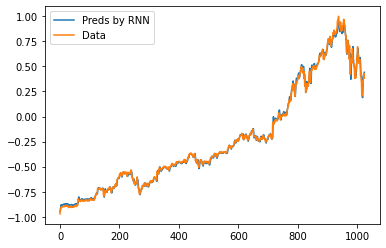

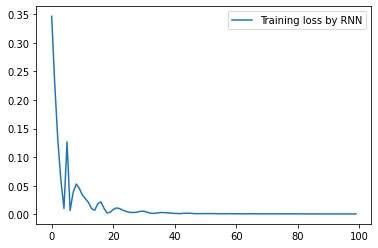

In [28]:
plt.plot(y_train_pred_rnn.detach().numpy(), label="Preds by RNN")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss by RNN")
plt.legend()
plt.show()

## Predicting test dataset

In [29]:
np.shape(y_train_pred_rnn)

torch.Size([1026, 1])

In [31]:
# make predictions
y_test_pred_rnn, y_h = rnn(x_test, None)

# invert predictions
y_train_pred_rnn = scaler.inverse_transform(y_train_pred_rnn.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred_rnn = scaler.inverse_transform(y_test_pred_rnn.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred_rnn[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred_rnn[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 24.67 RMSE
Test Score: 30.47 RMSE


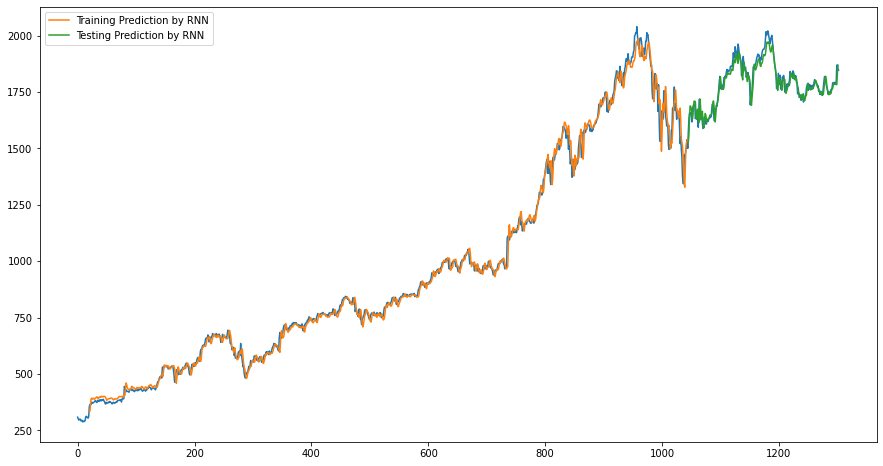

In [33]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_amzn)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred_rnn)+look_back, :] = y_train_pred_rnn

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_amzn)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred_rnn)+look_back-1:len(df_amzn)-1, :] = y_test_pred_rnn

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(df_amzn))
plt.plot(trainPredictPlot, label="Training Prediction by RNN")
plt.plot(testPredictPlot, label="Testing Prediction by RNN")
plt.legend()
plt.show()

# LSTM model

In [0]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [0]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

In [36]:
lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
print(lstm)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [37]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in lstm.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in lstm.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

12,961 total parameters.
12,961 training parameters.


In [0]:
loss_fn = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(lstm.parameters(), lr=0.01)

In [0]:
hist_lstm = np.zeros(num_epochs)
seq_dim =look_back-1
hidden = None

In [0]:
x_train, y_train, x_test, y_test = load_data(df_amzn, look_back)
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [41]:
for t in range(num_epochs):
    
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred_lstm = lstm(x_train)

    loss = loss_fn(y_train_pred_lstm, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist_lstm[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.05207819864153862
Epoch  20 MSE:  0.024744123220443726
Epoch  30 MSE:  0.011347644031047821
Epoch  40 MSE:  0.006839286535978317
Epoch  50 MSE:  0.0042412737384438515
Epoch  60 MSE:  0.0024693231098353863
Epoch  70 MSE:  0.001935563632287085
Epoch  80 MSE:  0.001589326886460185
Epoch  90 MSE:  0.0014268149388954043


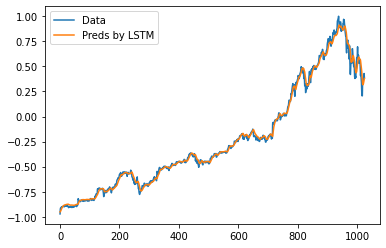

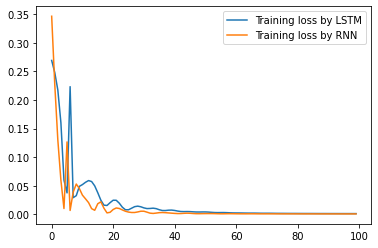

In [42]:
plt.plot(y_train.detach().numpy(), label="Data")
#plt.plot(y_train_pred_rnn.numpy(), label="Preds by RNN")
plt.plot(y_train_pred_lstm.detach().numpy(), label="Preds by LSTM")
plt.legend()
plt.show()

plt.plot(hist_lstm, label="Training loss by LSTM")
plt.plot(hist, label="Training loss by RNN")
plt.legend()
plt.show()

In [43]:
np.shape(y_train_pred_lstm)

torch.Size([1026, 1])

In [44]:
# make predictions
y_test_pred_lstm = lstm(x_test)

# invert predictions
y_train_pred_lstm = scaler.inverse_transform(y_train_pred_lstm.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred_lstm = scaler.inverse_transform(y_test_pred_lstm.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred_lstm[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred_lstm[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 32.21 RMSE
Test Score: 39.36 RMSE


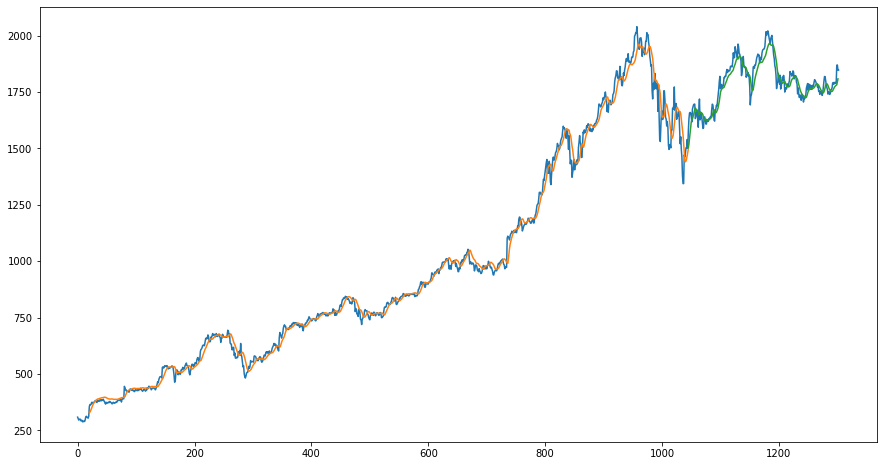

In [45]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_amzn)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred_lstm)+look_back, :] = y_train_pred_lstm

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_amzn)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred_lstm)+look_back-1:len(df_amzn)-1, :] = y_test_pred_lstm

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(df_amzn))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()